In [1]:
import os
import gc
import math
import random
from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.optim import Adam
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')

from train_models import ClassifierTrainer

In [ ]:
data_path = 'Module_6_Lecture_1_CoNLL2003/'

In [3]:
def load_sentences(filepath):
    final = []
    sentences = []
    with open(filepath, 'r') as f:
        for line in f.readlines():
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    return final

In [4]:
train_sents = load_sentences(data_path + 'train.txt')
test_sents = load_sentences(data_path + 'test.txt')
val_sents = load_sentences(data_path + 'valid.txt')

In [5]:
train_sents[0]

[('EU', 'B-ORG'),
 ('rejects', 'O'),
 ('German', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('British', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O')]

In [6]:
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
id2label = {str(i): label for i, label in enumerate(ner_labels)}
label2id = {value: int(key) for key, value in id2label.items()}

In [7]:
id2label

{'0': 'O',
 '1': 'B-PER',
 '2': 'I-PER',
 '3': 'B-ORG',
 '4': 'I-ORG',
 '5': 'B-LOC',
 '6': 'I-LOC',
 '7': 'B-MISC',
 '8': 'I-MISC'}

In [8]:
def get_df(samples):
    df,label = [], []
    for lines in samples:
        cur_line, cur_label = list(zip(*lines))
        df.append(list(cur_line))
        label.append([label2id[i] for i in cur_label])
    return {'text':df, 'label':label}

In [9]:
train_df = get_df(train_sents)
test_df = get_df(test_sents)
val_df = get_df(val_sents)

In [10]:
train_df['text'][0], train_df['label'][0]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 [3, 0, 7, 0, 0, 0, 7, 0, 0])

In [11]:
word_dict = defaultdict(int)

for line in train_df['text']:
    for word in line:
        word_dict[word] += 1

lower_freq_word = []
for k,v in word_dict.items():
    if v < 2:
        lower_freq_word.append(k)

for word in lower_freq_word:
    del word_dict[word]
    
word_dict['<UNK>'] = -1
word_dict['<PAD>'] = -2

word2id = {}

for idx, word in enumerate(word_dict.keys()):
    word2id[word] = idx

In [12]:
word2id

{'EU': 0,
 'German': 1,
 'call': 2,
 'to': 3,
 'boycott': 4,
 'British': 5,
 'lamb': 6,
 '.': 7,
 'Peter': 8,
 'Blackburn': 9,
 'BRUSSELS': 10,
 '1996-08-22': 11,
 'The': 12,
 'European': 13,
 'Commission': 14,
 'said': 15,
 'on': 16,
 'Thursday': 17,
 'it': 18,
 'disagreed': 19,
 'with': 20,
 'advice': 21,
 'consumers': 22,
 'until': 23,
 'scientists': 24,
 'determine': 25,
 'whether': 26,
 'mad': 27,
 'cow': 28,
 'disease': 29,
 'can': 30,
 'be': 31,
 'transmitted': 32,
 'sheep': 33,
 'Germany': 34,
 "'s": 35,
 'representative': 36,
 'the': 37,
 'Union': 38,
 'veterinary': 39,
 'committee': 40,
 'Werner': 41,
 'Zwingmann': 42,
 'Wednesday': 43,
 'should': 44,
 'buy': 45,
 'sheepmeat': 46,
 'from': 47,
 'countries': 48,
 'other': 49,
 'than': 50,
 'Britain': 51,
 'scientific': 52,
 'was': 53,
 '"': 54,
 'We': 55,
 'do': 56,
 "n't": 57,
 'support': 58,
 'any': 59,
 'such': 60,
 'recommendation': 61,
 'because': 62,
 'we': 63,
 'see': 64,
 'grounds': 65,
 'for': 66,
 ',': 67,
 'chief': 

In [13]:
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix.keys():
            idxs.append(to_ix[w])
        else:
            idxs.append(to_ix['<UNK>'])
    return idxs

In [14]:
class CoNLLDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text']
        self.labels = df['label']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_sequence(self.texts[item], word2id)
        label = self.labels[item]
        return {
            'input_ids': inputs,
            'labels': label
        }

class CollateForTrainer:
    def __call__(self, batch):
        input_ids = [s["input_ids"] for s in batch]
        labels = [s["labels"] for s in batch]
        max_len = max(len(s) for s in input_ids)

        input_ids = [s + [word2id['<PAD>']] * (max_len - len(s)) for s in input_ids]
        labels = [s + [-100] * (max_len - len(s)) for s in labels]
        attention_mask = [[1 if token != word2id['<PAD>'] else 0 for token in seq] for seq in input_ids]

        return {
            "input_ids": torch.tensor(input_ids),
            "labels": torch.tensor(labels),
            "attention_mask": torch.tensor(attention_mask)
        }

In [15]:
class BiLSTMNERTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) if embeddings is None \
                         else nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=3, batch_first=True)
        self.classifier = nn.Linear(2 * hidden_dim, output_size)

    def forward(self, input_ids, attention_mask=None):
        if input_ids.dtype != torch.long:
            input_ids = input_ids.long()
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        return self.classifier(x)

    
model = BiLSTMNERTagger(
    embedding_dim=100,
    hidden_dim=64,
    vocab_size=len(word2id),
    output_size=len(id2label)
)

In [16]:
train_dataset = CoNLLDataset(train_df)
val_dataset = CoNLLDataset(val_df)
test_dataset = CoNLLDataset(test_df)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=CollateForTrainer())
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=CollateForTrainer())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=CollateForTrainer())

In [18]:
parameters = list(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters())

In [19]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=len(id2label),
                            device='mps')

In [20]:
trainer.fit(train_loader,
            val_loader,
            num_epoch=10,
            info_every_iter=1,
            show_val_metrics=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] Train Loss: 0.5912 Acc: 0.2131 Rec: 0.2131 Prec: 0.4534
Epoch [2/10] Train Loss: 0.2299 Acc: 0.6043 Rec: 0.6043 Prec: 0.7379
Epoch [3/10] Train Loss: 0.1180 Acc: 0.8174 Rec: 0.8174 Prec: 0.8659
Epoch [4/10] Train Loss: 0.0726 Acc: 0.8889 Rec: 0.8889 Prec: 0.9172
Epoch [5/10] Train Loss: 0.0481 Acc: 0.9294 Rec: 0.9294 Prec: 0.9490
Epoch [6/10] Train Loss: 0.0334 Acc: 0.9528 Rec: 0.9528 Prec: 0.9648
Epoch [7/10] Train Loss: 0.0249 Acc: 0.9659 Rec: 0.9659 Prec: 0.9732
Epoch [8/10] Train Loss: 0.0189 Acc: 0.9749 Rec: 0.9749 Prec: 0.9805
Epoch [9/10] Train Loss: 0.0146 Acc: 0.9809 Rec: 0.9809 Prec: 0.9851
Epoch [10/10] Train Loss: 0.0118 Acc: 0.9853 Rec: 0.9853 Prec: 0.9884


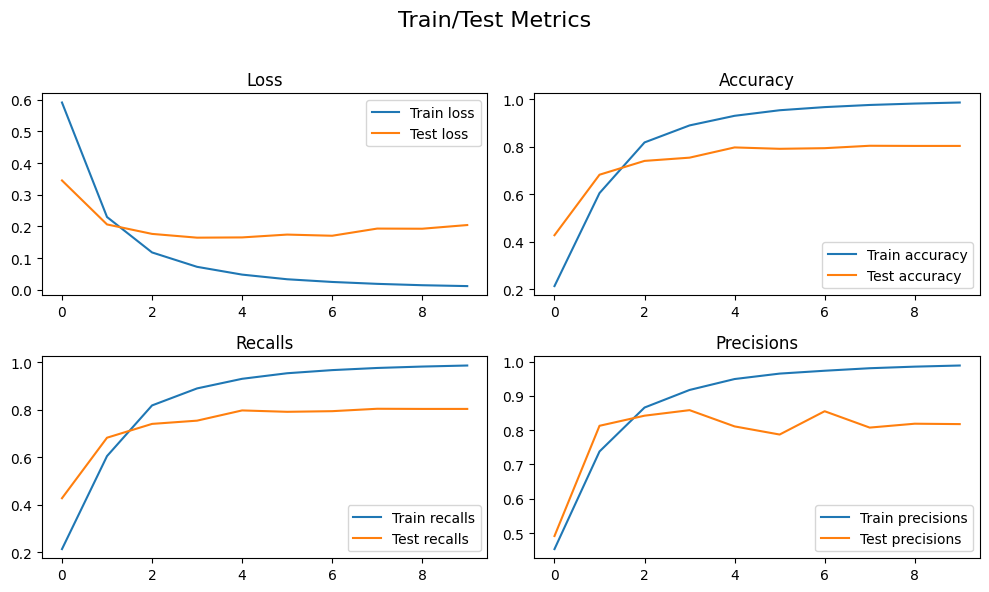

In [22]:
trainer.plot_metrics()